In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 그래프 기본설정\n",
# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12,6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
import pandas as pd

bat = pd.read_csv("../data/processed/team_year_batting_2021_2025.csv")
pit = pd.read_csv("../data/processed/team_year_pitching_2021_2025.csv")

bat.head(), pit.head()

(   Year Team    PA    AB    R     H   2B  3B   HR    TB  ...  BB_HBP_PA  \
 0  2021  KIA  5577  4831  568  1198  183  21   66  1621  ...   0.119778   
 1  2021   KT  5626  4810  719  1276  219  11  106  1835  ...   0.124778   
 2  2021   LG  5533  4750  654  1188  210  11  110  1750  ...   0.123983   
 3  2021   NC  5530  4806  702  1254  203  17  170  2001  ...   0.112477   
 4  2021  SSG  5735  4898  755  1278  204  13  185  2063  ...   0.127289   
 
       SO_PA     HR_PA  AVG_calc  OBP_calc  SLG_calc  ISO_calc      R_PA  \
 0  0.165143  0.011834  0.247982  0.337066  0.335541  0.087560  0.101847   
 1  0.186100  0.018841  0.265281  0.356012  0.381497  0.116216  0.127800   
 2  0.167359  0.019881  0.250105  0.341908  0.368421  0.118316  0.118200   
 3  0.197649  0.030741  0.260924  0.342899  0.416355  0.155431  0.126944   
 4  0.183958  0.032258  0.260923  0.353521  0.421192  0.160269  0.131648   
 
    H_minus_HR_PA    GDP_PA  
 0       0.202977  0.021338  
 1       0.207963  0.018

In [3]:
# 분석에 사용할 공격 / 투수 지표 리스트 (01 전체에서 공통 사용)

off_metrics = [
    "OBP_calc",
    "BB_HBP_PA",
    "SO_PA",
    "ISO_calc",
    "HR_PA",
    "R_PA",
    "H_minus_HR_PA",
    "GDP_PA",
]

pit_metrics = [
    "ERA",
    "FIP",
    "BB_9",
    "K_9",
    "HR_9",
    "H_9",
]

# 투수 방향(좋을수록 + 로 통일할 때 사용)
pit_direction = {
    "ERA": -1,
    "FIP": -1,
    "BB_9": -1,
    "HR_9": -1,
    "H_9": -1,
    "K_9": +1,
}

In [4]:
# 이름 확인
sorted(bat["Team"].dropna().unique())

['KIA', 'KT', 'LG', 'NC', 'SSG', '두산', '롯데', '삼성', '키움', '한화']

In [5]:
bat.columns

Index(['Year', 'Team', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'TB', 'RBI',
       'SB', 'CS', 'BB', 'HP', 'SO', 'GDP', 'SH', 'SF', 'ePA', 'BB_HBP_PA',
       'SO_PA', 'HR_PA', 'AVG_calc', 'OBP_calc', 'SLG_calc', 'ISO_calc',
       'R_PA', 'H_minus_HR_PA', 'GDP_PA'],
      dtype='object')

In [6]:
bat["Team_norm"] = bat["Team"].astype(str).str.strip()
pit["Team_norm"] = pit["Team"].astype(str).str.strip()

sorted(bat["Team_norm"].dropna().unique())

['KIA', 'KT', 'LG', 'NC', 'SSG', '두산', '롯데', '삼성', '키움', '한화']

In [7]:
# 챔피언 팀 분류
champ_by_year = {
    2021: "KT",
    2022: "SSG",
    2023: "LG",
    2024: "KIA",
    2025: "LG",
}

In [8]:
# 1) 챔피언 매핑 df
champ_df = pd.DataFrame({
    "Year": list(champ_by_year.keys()),
    "Team_norm": list(champ_by_year.values())
})

In [9]:
# 2) merge로 우승팀 추출
bat_champs = bat.merge(champ_df, on=["Year", "Team_norm"], how="inner")
pit_champs = pit.merge(champ_df, on=["Year", "Team_norm"], how="inner")

In [10]:
# 3) sanity check (연도별 1팀씩 5행이어야 정상)
print("bat_champs:", bat_champs.shape)
print("pit_champs:", pit_champs.shape)
print(bat_champs[["Year","Team_norm"]].drop_duplicates().sort_values("Year"))

bat_champs: (5, 31)
pit_champs: (5, 15)
   Year Team_norm
0  2021        KT
1  2022       SSG
2  2023        LG
3  2024       KIA
4  2025        LG


In [11]:
# 우승팀 매칭 실패하는 연도 확인
for y, champ in champ_by_year.items():
    exists = ((bat["Year"] == y) & (bat["Team_norm"] == champ)).any()
    print(y, champ, "OK" if exists else "NOT FOUND")

2021 KT OK
2022 SSG OK
2023 LG OK
2024 KIA OK
2025 LG OK


In [12]:
strong_off_model = bat_champs[off_metrics].mean(numeric_only=True)
strong_pit_model = pit_champs[pit_metrics].mean(numeric_only=True)

strong_off_model, strong_pit_model

(OBP_calc         0.356680
 BB_HBP_PA        0.113913
 SO_PA            0.169233
 ISO_calc         0.132441
 HR_PA            0.022092
 R_PA             0.135178
 H_minus_HR_PA    0.216271
 GDP_PA           0.017828
 dtype: float64,
 ERA     3.936594
 FIP     5.663156
 BB_9    3.472436
 K_9     7.410956
 HR_9    0.733741
 H_9     8.816839
 dtype: float64)

---

In [13]:
target_team = "삼성"

In [14]:
# 타깃팀 평균
target_off = bat[bat["Team_norm"] == target_team]
target_pit = pit[pit["Team_norm"] == target_team]

target_off_avg = target_off[off_metrics].mean(numeric_only=True)
target_pit_avg = target_pit[pit_metrics].mean(numeric_only=True)

In [15]:
# diff (타깃 - 우승팀 strong)
diff_off = (target_off_avg - strong_off_model).to_frame("Diff(Target-StrongChampion)")
diff_pit = (target_pit_avg - strong_pit_model).to_frame("Diff(Target-StrongChampion)")

In [16]:
# 투수는 좋을수록 + 로 통일한 버전도 같이
diff_pit_aligned = diff_pit.copy()
for m, sgn in pit_direction.items():
    diff_pit_aligned.loc[m, "Diff(Target-StrongChampion)"] *= sgn

diff_off, diff_pit, diff_pit_aligned

(               Diff(Target-StrongChampion)
 OBP_calc                         -0.014353
 BB_HBP_PA                        -0.010294
 SO_PA                             0.012605
 ISO_calc                          0.001400
 HR_PA                             0.001673
 R_PA                             -0.008888
 H_minus_HR_PA                    -0.005355
 GDP_PA                            0.001042,
       Diff(Target-StrongChampion)
 ERA                      0.496368
 FIP                      0.103238
 BB_9                    -0.062712
 K_9                     -0.409698
 HR_9                     0.224569
 H_9                      0.712801,
       Diff(Target-StrongChampion)
 ERA                     -0.496368
 FIP                     -0.103238
 BB_9                     0.062712
 K_9                     -0.409698
 HR_9                    -0.224569
 H_9                     -0.712801)

In [17]:
bat_champs[["Year","Team_norm"]].drop_duplicates().sort_values("Year")

,Year,Team_norm
0,2021,KT
1,2022,SSG
2,2023,LG
3,2024,KIA
4,2025,LG


투수 구조는 타자에 비해 이벤트 종류가 제한적이기 때문에,
본 프로젝트에서는 실점 억제 구조를 설명하는 최소 핵심 지표 세트를 우선 채택하였다.

필요 시 FIP 및 피안타 허용률(H/9)을 보조 지표로 활용하여,
결과(ERA)와 구조적 재현 가능성 간의 차이를 해석한다.

In [18]:
pit_champs[["Year","Team_norm"]].drop_duplicates().sort_values("Year")

,Year,Team_norm
0,2021,KT
1,2022,SSG
2,2023,LG
3,2024,KIA
4,2025,LG


In [19]:
[df_name for df_name, df_val in globals().items() if isinstance(df_val, pd.DataFrame)]

['_',
 '__',
 'bat',
 'pit',
 'champ_df',
 'bat_champs',
 'pit_champs',
 'target_off',
 'target_pit',
 'diff_off',
 'diff_pit',
 'diff_pit_aligned',
 '_17',
 '_18']

In [20]:
import os

OUT_DIR = "./artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

In [21]:
# 1) 공격/투수 Strong Champion Model 각각 저장
bat_champs.to_csv(
    os.path.join(OUT_DIR, "01_strong_champion_model_batting.csv"),
    index=False,
    encoding="utf-8-sig"
)

pit_champs.to_csv(
    os.path.join(OUT_DIR, "01_strong_champion_model_pitching.csv"),
    index=False,
    encoding="utf-8-sig"
)

In [22]:
# 2) (선택) 공격+투수 합쳐둔 champ_df도 같이 저장
champ_df.to_csv(
    os.path.join(OUT_DIR, "01_strong_champion_model_full.csv"),
    index=False,
    encoding="utf-8-sig"
)

print("✅ Saved 01 outputs:")
print(" -", os.path.join(OUT_DIR, "01_strong_champion_model_batting.csv"))
print(" -", os.path.join(OUT_DIR, "01_strong_champion_model_pitching.csv"))
print(" -", os.path.join(OUT_DIR, "01_strong_champion_model_full.csv"))

✅ Saved 01 outputs:
 - ./artifacts/01_strong_champion_model_batting.csv
 - ./artifacts/01_strong_champion_model_pitching.csv
 - ./artifacts/01_strong_champion_model_full.csv


---
#### 레포트용 시각화

In [23]:
TEAM_COLORS = {
    '한화': '#FC4E00', 
    'LG': '#C30452', 
    'KIA': '#EA0029', 
    'SSG': '#CE0E2D',
    '삼성':'#074CA1', 
    'NC':'#315288', 
    'KT':'#000000', 
    '롯데':'#041E42', 
    '두산':'#1A1748',
    '키움':'#570514',
    'KBO': '#003A8F'
}

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Color Palette
# -------------------------
KBO_COLOR = TEAM_COLORS["KBO"]

# -------------------------
# Helpers
# -------------------------
def minmax_scale(series, vmin, vmax):
    x = series.astype(float).copy()
    denom = (vmax - vmin).astype(float)
    denom = denom.replace(0, 1e-12)  # 분모 0 방지
    return (x - vmin) / denom

def radar_single(labels, values, title, line_color="#003A8F", fill_alpha=0.20):
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    vals = list(values) + [values[0]]
    angles += angles[:1]

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, vals, linewidth=2.2, color=line_color)
    ax.fill(angles, vals, alpha=fill_alpha, color=line_color)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title, pad=18)
    ax.grid(True, alpha=0.35)

    plt.tight_layout()
    plt.show()

def align_pitching(series, direction_map):
    s = series.copy()
    for m, sgn in direction_map.items():
        s.loc[m] = s.loc[m] * sgn
    return s


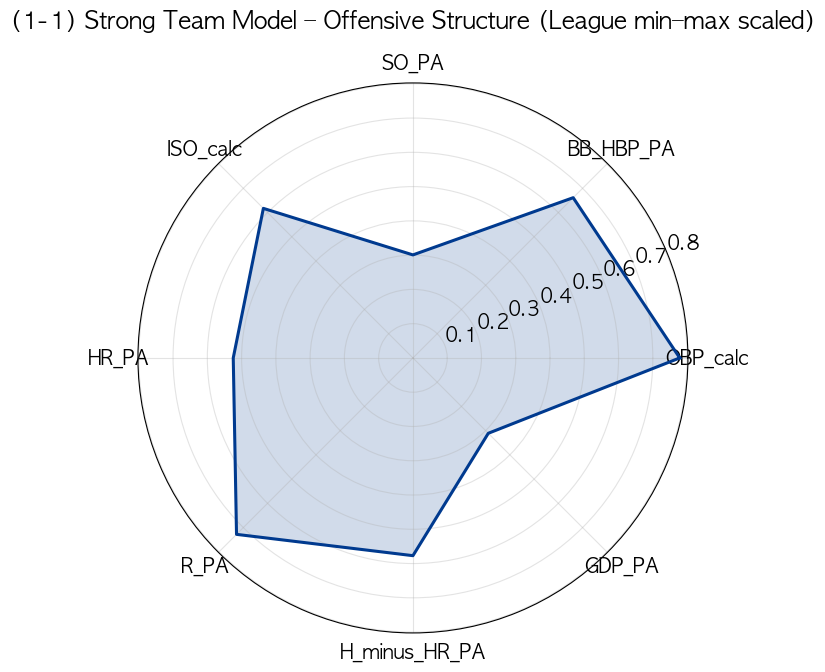

In [25]:
# Strong Team Model – 공격 구조 레이더 (KBO 블루)
# 리그(2021-2025) 기준 min/max로 정규화
league_off_min = bat[off_metrics].min(numeric_only=True)
league_off_max = bat[off_metrics].max(numeric_only=True)

strong_off_scaled = minmax_scale(strong_off_model, league_off_min, league_off_max)

radar_single(
    labels=off_metrics,
    values=strong_off_scaled.values,
    title="(1-1) Strong Team Model – Offensive Structure (League min–max scaled)",
    line_color=KBO_COLOR,
    fill_alpha=0.18
)

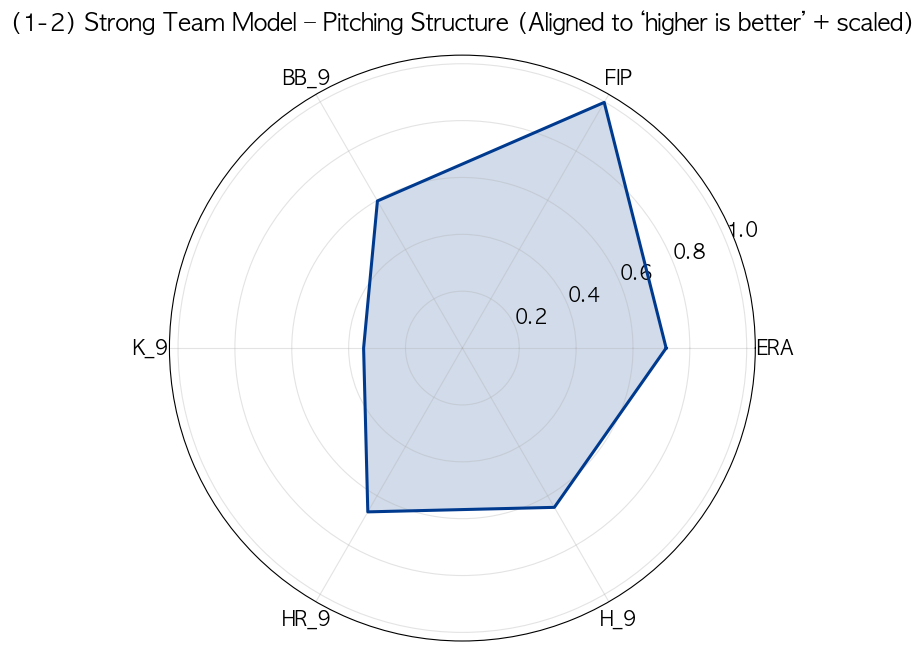

In [26]:
# Strong Team Model – 투수 구조 레이더 (좋을수록 + 정렬 + KBO 블루)
# Strong 투수 모델: 좋을수록 + 방향 정렬
strong_pit_aligned = align_pitching(strong_pit_model, pit_direction)

# 리그 전체도 동일 정렬 후 min/max
pit_aligned_df = pit[pit_metrics].copy()
for m, sgn in pit_direction.items():
    pit_aligned_df[m] = pit_aligned_df[m] * sgn

league_pit_min = pit_aligned_df[pit_metrics].min(numeric_only=True)
league_pit_max = pit_aligned_df[pit_metrics].max(numeric_only=True)

strong_pit_scaled = minmax_scale(strong_pit_aligned, league_pit_min, league_pit_max)

radar_single(
    labels=pit_metrics,
    values=strong_pit_scaled.values,
    title="(1-2) Strong Team Model – Pitching Structure (Aligned to ‘higher is better’ + scaled)",
    line_color=KBO_COLOR,
    fill_alpha=0.18
)


In [27]:
# 기준 수치 표
strong_off_table = strong_off_model.rename("Strong_Offense").to_frame()
strong_pit_table = strong_pit_model.rename("Strong_Pitching").to_frame()

display(strong_off_table)
display(strong_pit_table)


,Strong_Offense
OBP_calc,0.356680
BB_HBP_PA,0.113913
SO_PA,0.169233
ISO_calc,0.132441
HR_PA,0.022092
R_PA,0.135178
H_minus_HR_PA,0.216271
GDP_PA,0.017828


,Strong_Pitching
ERA,3.936594
FIP,5.663156
BB_9,3.472436
K_9,7.410956
HR_9,0.733741
H_9,8.816839


---

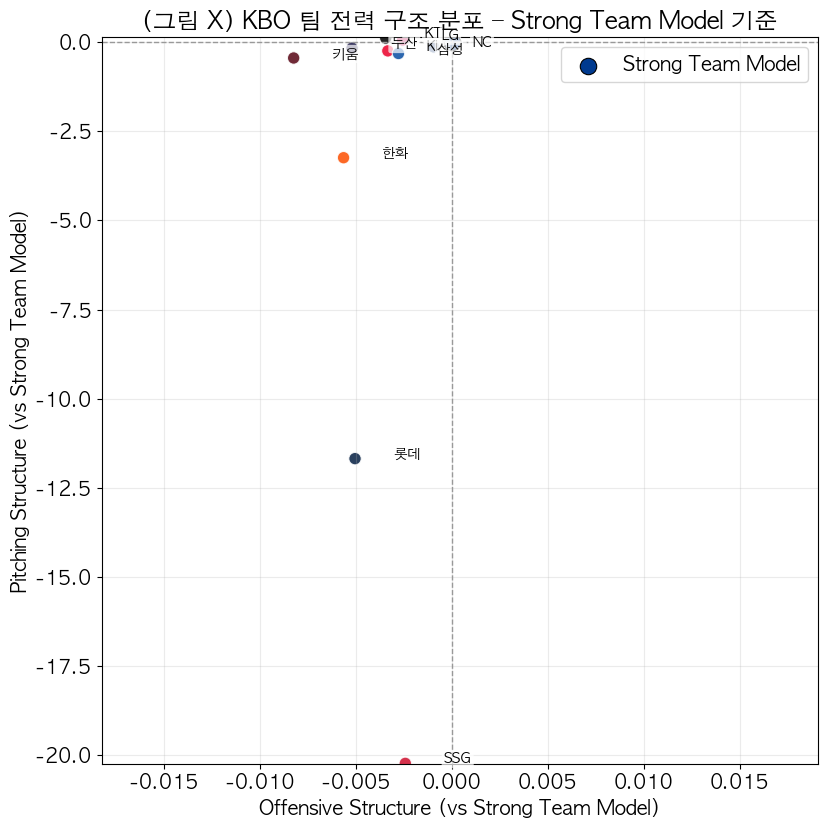

In [28]:
# 팀별 5개년 평균
team_off_avg = bat.groupby("Team_norm")[off_metrics].mean(numeric_only=True)
team_pit_avg = pit.groupby("Team_norm")[pit_metrics].mean(numeric_only=True)

# 공격 diff (팀 - Strong)
diff_off_all = team_off_avg.subtract(strong_off_model, axis=1)

# 투수 diff (팀 - Strong)
diff_pit_all = team_pit_avg.subtract(strong_pit_model, axis=1)

# 투수 방향 정렬 (좋을수록 +)
diff_pit_all_aligned = diff_pit_all.copy()
for m, sgn in pit_direction.items():
    diff_pit_all_aligned[m] *= sgn

# 공격/투수 구조 점수(평균)로 축소
team_struct_score = pd.DataFrame({
    "Offense_Score": diff_off_all.mean(axis=1),
    "Pitching_Score": diff_pit_all_aligned.mean(axis=1)
}).reset_index()

# 팀별 색상 매핑 (Team_norm과 딕셔너리 키가 다를 경우 대비)
def get_team_color(team_name):
    return TEAM_COLORS.get(team_name, "#666666")  # 없으면 회색

colors = [get_team_color(t) for t in team_struct_score["Team_norm"]]

plt.figure(figsize=(8.5, 8.5))

# 팀 점(컬러 적용)
plt.scatter(
    team_struct_score["Offense_Score"],
    team_struct_score["Pitching_Score"],
    c=colors,
    alpha=0.85,
    s=80,
    edgecolors="white",
    linewidths=0.8
)

# 팀명 표시(가독성용 bbox)
for _, row in team_struct_score.iterrows():
    plt.text(
        row["Offense_Score"] + 0.002,
        row["Pitching_Score"] + 0.002,
        row["Team_norm"],
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7)
    )

# 기준선(0,0): Strong Team Model (KBO 블루로 통일)
plt.axhline(0, color="#999999", linestyle="--", linewidth=1)
plt.axvline(0, color="#999999", linestyle="--", linewidth=1)
plt.scatter(0, 0, color=KBO_COLOR, s=140, label="Strong Team Model", edgecolors="black", linewidths=0.8)

plt.xlim(team_struct_score["Offense_Score"].min() - 0.01, team_struct_score["Offense_Score"].max() + 0.02)
plt.ylim(team_struct_score["Pitching_Score"].min() - 0.01, team_struct_score["Pitching_Score"].max() + 0.02)


plt.xlabel("Offensive Structure (vs Strong Team Model)")
plt.ylabel("Pitching Structure (vs Strong Team Model)")
plt.title("(그림 X) KBO 팀 전력 구조 분포 – Strong Team Model 기준")

plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


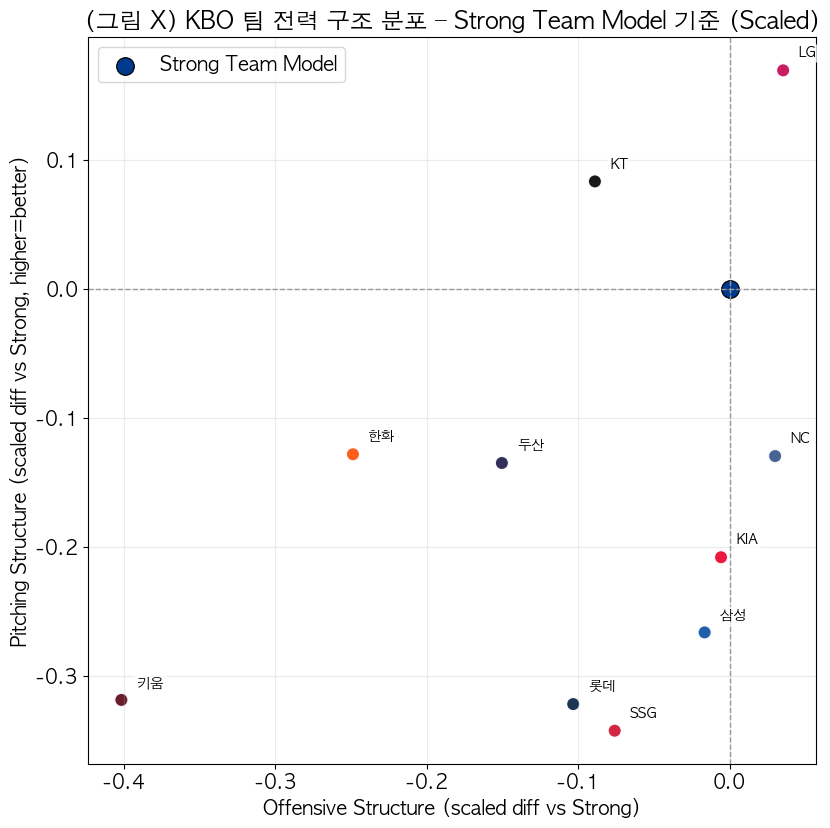

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

KBO_COLOR = TEAM_COLORS["KBO"]

def minmax_scale_df(df, cols):
    vmin = df[cols].min(numeric_only=True)
    vmax = df[cols].max(numeric_only=True)
    denom = (vmax - vmin).replace(0, 1e-12)
    return (df[cols] - vmin) / denom, vmin, vmax

def align_pitching_df(df, direction_map, cols):
    out = df.copy()
    for m, sgn in direction_map.items():
        if m in cols:
            out[m] = out[m] * sgn
    return out

# 1) 팀별 5개년 평균
team_off_avg = bat.groupby("Team_norm")[off_metrics].mean(numeric_only=True)
team_pit_avg = pit.groupby("Team_norm")[pit_metrics].mean(numeric_only=True)

# 2) Strong Team Model (Series)도 DF 형태로 맞춰두기
strong_off_df = strong_off_model.to_frame().T
strong_pit_df = strong_pit_model.to_frame().T

# 3) 스케일 통일을 위한 "리그 전체 데이터" 준비 (팀-연도 원본을 그대로 사용)
#    - 공격: 그대로
#    - 투수: 좋을수록 + 정렬 후 스케일
pit_aligned = align_pitching_df(pit, pit_direction, pit_metrics)

# 4) 공격: 리그 min-max로 스케일링
bat_scaled, off_min, off_max = minmax_scale_df(bat, off_metrics)
team_off_scaled, _, _ = minmax_scale_df(team_off_avg.reset_index(), off_metrics)
team_off_scaled = team_off_scaled.set_index(team_off_avg.index)

# Strong 공격도 같은 기준으로 스케일
strong_off_scaled = (strong_off_model - off_min) / (off_max - off_min).replace(0, 1e-12)

# 5) 투수: 방향 정렬 후 리그 min-max로 스케일링
pit_scaled, pit_min, pit_max = minmax_scale_df(pit_aligned, pit_metrics)

# 팀 평균도 방향 정렬 후 스케일
team_pit_avg_aligned = align_pitching_df(team_pit_avg.reset_index(), pit_direction, pit_metrics)
team_pit_scaled, _, _ = minmax_scale_df(team_pit_avg_aligned, pit_metrics)
team_pit_scaled = team_pit_scaled.set_index(team_pit_avg.index)

# Strong 투수도 같은 기준으로 스케일
strong_pit_aligned = strong_pit_model.copy()
for m, sgn in pit_direction.items():
    strong_pit_aligned.loc[m] *= sgn
strong_pit_scaled = (strong_pit_aligned - pit_min) / (pit_max - pit_min).replace(0, 1e-12)

# 6) 이제 "스케일 통일된" diff로 구조 점수 생성 (팀 - Strong)
diff_off_scaled = team_off_scaled.subtract(strong_off_scaled, axis=1)
diff_pit_scaled = team_pit_scaled.subtract(strong_pit_scaled, axis=1)

team_struct_score = pd.DataFrame({
    "Team_norm": team_off_avg.index,
    "Offense_Score": diff_off_scaled.mean(axis=1),
    "Pitching_Score": diff_pit_scaled.mean(axis=1)
})

# 7) 팀 색상
def get_team_color(team_name):
    return TEAM_COLORS.get(team_name, "#666666")

colors = [get_team_color(t) for t in team_struct_score["Team_norm"]]

# 8) 산점도
plt.figure(figsize=(8.5, 8.5))

plt.scatter(
    team_struct_score["Offense_Score"],
    team_struct_score["Pitching_Score"],
    c=colors,
    alpha=0.9,
    s=90,
    edgecolors="white",
    linewidths=0.9
)

# 라벨
for _, row in team_struct_score.iterrows():
    plt.text(
        row["Offense_Score"] + 0.01,
        row["Pitching_Score"] + 0.01,
        row["Team_norm"],
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.75)
    )

# 기준선 (Strong = 0,0)
plt.axhline(0, color="#999999", linestyle="--", linewidth=1)
plt.axvline(0, color="#999999", linestyle="--", linewidth=1)
plt.scatter(0, 0, color=KBO_COLOR, s=160, label="Strong Team Model", edgecolors="black", linewidths=0.9)

plt.xlabel("Offensive Structure (scaled diff vs Strong)")
plt.ylabel("Pitching Structure (scaled diff vs Strong, higher=better)")
plt.title("(그림 X) KBO 팀 전력 구조 분포 – Strong Team Model 기준 (Scaled)")

plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


---
#### (표 2-1) Strong Team Model 기준 수치표

In [30]:
# --------------------------------
# (표 2-1) Strong Team Model 기준 수치표
# --------------------------------

# 공격 기준 수치
strong_off_summary = (
    strong_off_model
    .rename("Strong Team Model")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "Metric"})
)
strong_off_summary["Category"] = "Offense"

# 투수 기준 수치
strong_pit_summary = (
    strong_pit_model
    .rename("Strong Team Model")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "Metric"})
)
strong_pit_summary["Category"] = "Pitching"

# 공격 + 투수 통합
strong_model_summary = pd.concat(
    [strong_off_summary, strong_pit_summary],
    ignore_index=True
)

# 컬럼 정렬
strong_model_summary = strong_model_summary[
    ["Category", "Metric", "Strong Team Model"]
]

display(strong_model_summary)

,Category,Metric,Strong Team Model
0,Offense,OBP_calc,0.356680
1,Offense,BB_HBP_PA,0.113913
2,Offense,SO_PA,0.169233
3,Offense,ISO_calc,0.132441
4,Offense,HR_PA,0.022092
5,Offense,R_PA,0.135178
6,Offense,H_minus_HR_PA,0.216271
7,Offense,GDP_PA,0.017828
8,Pitching,ERA,3.936594
9,Pitching,FIP,5.663156


In [31]:
OUT_DIR = "./artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

strong_model_summary.to_csv(
    os.path.join(OUT_DIR, "01_strong_team_model_reference_table.csv"),
    index=False,
    encoding="utf-8-sig"
)

print("✅ Saved:")
print(" -", os.path.join(OUT_DIR, "01_strong_team_model_reference_table.csv"))


✅ Saved:
 - ./artifacts/01_strong_team_model_reference_table.csv
